In [82]:
import os
os.chdir('/workspaces/walker')
import numpy as np
import pandas as pd
import seaborn as sns

In [83]:
# generate random data
nrows = 100000
raw_df = pd.concat([
    pd.DataFrame({
        'segment': np.random.choice(['A'], size=nrows),
        'time': np.random.choice(['01-Jan'], size=nrows),
        'outcome': np.random.choice([0, 1], size=nrows),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['B'], size=nrows),
        'time': np.random.choice(['01-Jan'], size=nrows),
        'outcome': np.random.choice([0, 1], size=nrows),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['A'], size=nrows * 3),
        'time': np.random.choice(['02-Feb'], size=nrows * 3),
        'outcome': np.random.choice([0, 1, 1, 1], size=nrows * 3),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['B'], size=nrows),
        'time': np.random.choice(['02-Feb'], size=nrows),
        'outcome': np.random.choice([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], size=nrows),
    }),
])

In [84]:
aggs = raw_df \
    .groupby(['segment', 'time'], as_index=False) \
    .agg(
        count=('outcome', 'count'),
        performance=('outcome', 'mean')
    )
aggs

,segment,time,count,performance
0,A,01-Jan,100000,0.498690
1,A,02-Feb,300000,0.750133
2,B,01-Jan,100000,0.499380
3,B,02-Feb,100000,0.923820


In [85]:
pivot = aggs.pivot(
    index='segment',
    columns='time',
    values=['count', 'performance']
)
pivot.columns = ['|'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()
pivot

,segment,count|01-Jan,count|02-Feb,performance|01-Jan,performance|02-Feb
0,A,100000.0,300000.0,0.49869,0.750133
1,B,100000.0,100000.0,0.49938,0.923820


In [86]:
segments = np.sort(raw_df['segment'].unique()).tolist()
times = np.sort(raw_df['time'].unique()).tolist()

In [87]:
# calculate total counts
total_p0 = pivot[f'count|{times[0]}'].sum()
total_p1 = pivot[f'count|{times[1]}'].sum()

In [88]:
# convert counts to proportions
pivot[f'proportion|{times[0]}'] = pivot[f'count|{times[0]}'] / total_p0
pivot[f'proportion|{times[1]}'] = pivot[f'count|{times[1]}'] / total_p1

In [89]:
# calculate changes and averages
pivot['change_proportion'] = pivot[f'proportion|{times[1]}'] - pivot[f'proportion|{times[0]}']
pivot['change_performance'] = pivot[f'performance|{times[1]}'] - pivot[f'performance|{times[0]}']
pivot['average_proportion'] = (pivot[f'proportion|{times[0]}'] + pivot[f'proportion|{times[1]}']) / 2
pivot['average_performance'] = (pivot[f'performance|{times[0]}'] + pivot[f'performance|{times[1]}']) / 2

In [90]:
# overall performance at each time point
overall_performance_0 = (pivot[f'proportion|{times[0]}'] * pivot[f'performance|{times[0]}']).sum()
overall_performance_1 = (pivot[f'proportion|{times[1]}'] * pivot[f'performance|{times[1]}']).sum()
overall_performance_change = overall_performance_1 - overall_performance_0

In [91]:
# decomposition of total change
pivot['between_group_contribution'] = pivot[f'performance|{times[0]}'] * pivot['change_proportion']
pivot['within_group_contribution'] = pivot[f'proportion|{times[1]}'] * pivot['change_performance']
within_group_contribution = pivot['within_group_contribution'].sum()
between_group_contribution = pivot['between_group_contribution'].sum()

In [92]:
# sum up the effects
within_group_contribution = pivot['within_group_contribution'].sum()
between_group_contribution = pivot['between_group_contribution'].sum()
total_contribution = within_group_contribution + between_group_contribution


In [93]:
pretty_results = pd.concat([
    pivot.loc[:, [
        'segment',
        f'count|{times[0]}',
        f'proportion|{times[0]}',
        f'count|{times[1]}',
        f'proportion|{times[1]}',
        'change_proportion',

        f'performance|{times[0]}',
        f'performance|{times[1]}',
        'change_performance',

        'within_group_contribution',
        'between_group_contribution',
    ]],
    pd.DataFrame({
        'segment': 'Total',
        f'count|{times[0]}': total_p0,
        f'proportion|{times[0]}': 1,
        f'count|{times[1]}': total_p1,
        f'proportion|{times[1]}': 1,
        'change_proportion': np.nan,

        f'performance|{times[0]}': overall_performance_0,
        f'performance|{times[1]}': overall_performance_1,
        'change_performance': overall_performance_change,

        'within_group_contribution': within_group_contribution,
        'between_group_contribution': between_group_contribution,
    }, index=[len(segments)])
])
pretty_results['total_contribution'] = pretty_results['within_group_contribution'] + pretty_results['between_group_contribution']
for col in ['within_group_contribution', 'between_group_contribution', 'total_contribution']:
    pretty_results[col+'_pct'] = pretty_results[col] / total_contribution
pretty_results

,segment,count|01-Jan,proportion|01-Jan,count|02-Feb,proportion|02-Feb,change_proportion,performance|01-Jan,performance|02-Feb,change_performance,within_group_contribution,between_group_contribution,total_contribution,within_group_contribution_pct,between_group_contribution_pct,total_contribution_pct
0,A,100000.0,0.5,300000.0,0.75,0.25,0.498690,0.750133,0.251443,0.188582,0.124673,0.313255,0.640305,0.423307,1.063612
1,B,100000.0,0.5,100000.0,0.25,-0.25,0.499380,0.923820,0.424440,0.106110,-0.124845,-0.018735,0.360281,-0.423893,-0.063612
2,Total,200000.0,1.0,400000.0,1.00,NaN,0.499035,0.793555,0.294520,0.294692,-0.000172,0.294520,1.000586,-0.000586,1.000000


# Proportion Change

<Axes: xlabel='segment', ylabel='count'>

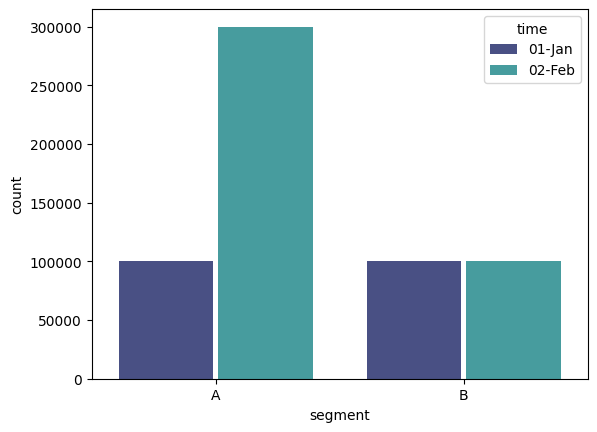

In [94]:
sns.set_palette(sns.color_palette("mako", 2))
sns.barplot(aggs, x="segment", y="count", hue="time", gap=0.05)

In [95]:
pretty_results_proportion = pretty_results.loc[:, [
    'segment',
    f'count|{times[0]}',
    f'proportion|{times[0]}',
    f'count|{times[1]}',
    f'proportion|{times[1]}',
    'change_proportion',
    'between_group_contribution',
    'between_group_contribution_pct',
]]
pretty_results_proportion

,segment,count|01-Jan,proportion|01-Jan,count|02-Feb,proportion|02-Feb,change_proportion,between_group_contribution,between_group_contribution_pct
0,A,100000.0,0.5,300000.0,0.75,0.25,0.124673,0.423307
1,B,100000.0,0.5,100000.0,0.25,-0.25,-0.124845,-0.423893
2,Total,200000.0,1.0,400000.0,1.00,NaN,-0.000172,-0.000586


# Performance Change

<Axes: xlabel='segment', ylabel='performance'>

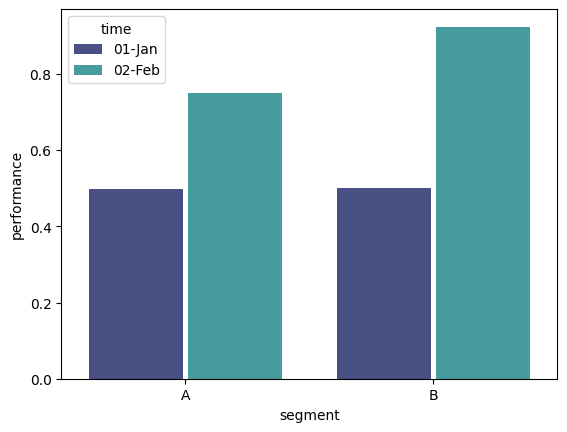

In [96]:
sns.set_palette(sns.color_palette("mako", 2))
sns.barplot(aggs, x="segment", y="performance", hue="time", gap=0.05)

# Absolute Contributions

In [107]:
pretty_results_condensed = pretty_results.loc[pretty_results['segment'].isin(segments), [
    'segment',
    'within_group_contribution',
    'between_group_contribution',
]]
pretty_results_condensed['within_group_contribution'] = pretty_results_condensed['within_group_contribution'].abs()
pretty_results_condensed['between_group_contribution'] = pretty_results_condensed['between_group_contribution'].abs()
total_absolute_contribution = pretty_results_condensed['within_group_contribution'].sum() + pretty_results_condensed['between_group_contribution'].sum()
pretty_results_condensed['within_group_contribution'] = pretty_results_condensed['within_group_contribution'] / total_absolute_contribution
pretty_results_condensed['between_group_contribution'] = pretty_results_condensed['between_group_contribution'] / total_absolute_contribution
pretty_results_condensed['total_contribution'] = pretty_results_condensed['within_group_contribution'] + pretty_results_condensed['between_group_contribution']
pretty_results_condensed

,segment,within_group_contribution,between_group_contribution,total_contribution
0,A,0.346525,0.229089,0.575614
1,B,0.194980,0.229406,0.424386


<Axes: xlabel='segment', ylabel='contribution'>

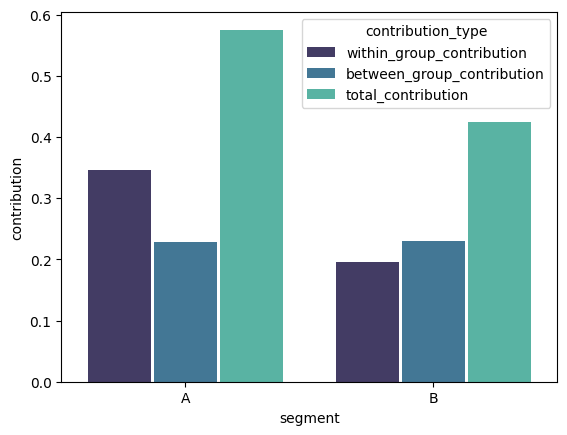

In [114]:
sns.set_palette(sns.color_palette("mako", 3))
sns.barplot(pretty_results_condensed.melt(id_vars='segment', var_name='contribution_type', value_name='contribution'), 
            x="segment", y="contribution", hue="contribution_type", gap=0.05)